<b>Customer churn rate</b> 

Customer churn is a critical challenge for businesses, particularly in sectors like banking, telecommunications, and subscription-based services. The ability to predict which customers are likely to leave allows companies to implement proactive retention strategies, reducing lost revenue and improving customer satisfaction.

This project focuses on building a churn prediction model using machine learning techniques. The dataset from (https://www.kaggle.com/competitions/bank-churn-lessgo) includes key customer attributes such as credit score, geography, gender, age, tenure, account balance, and product usage patterns, along with whether the customer has churned (Exited). By leveraging Exploratory Data Analysis (EDA) and machine learning models, I aim to extract insights into customer behavior and develop a predictive system that can estimate the likelihood of churn for new customers.

The models used in this project include:

Logistic Regression – A simple and interpretable model that establishes a baseline.
Random Forest Classifier – A more robust ensemble-based model that captures complex patterns.
XGBoost Classifier – A powerful gradient boosting algorithm optimized for structured data.

Model performance is evaluated using the Area Under the ROC Curve (AUC-ROC) to measure how well the models distinguish between churned and retained customers. Finally, the best-performing models generate predictions for an unseen test dataset, with submission files formatted accordingly.

This project not only demonstrates predictive modeling skills but also showcases data visualization techniques, feature engineering, and performance evaluation, all of which are essential in real-world data science applications.

First step as always, to import all important libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
# Load the training dataset
df_train = pd.read_csv("train.csv")

# Load the test dataset
df_test = pd.read_csv("test.csv")

This section will look at exploratory data analysis. A quick look into the basic information of the data, the type of data being dealt with and to see if the data is balanced.

In [3]:
print(df_train.info())
print(df_train.describe())
print(df_train["Exited"].value_counts(normalize=True))  # Check class balance

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB
None
                 id    CustomerId   CreditScore           Age       Tenure  \
count  15

Further more, some key views for the dataset we have are shown below so as to see if there are any key insights within the data. 

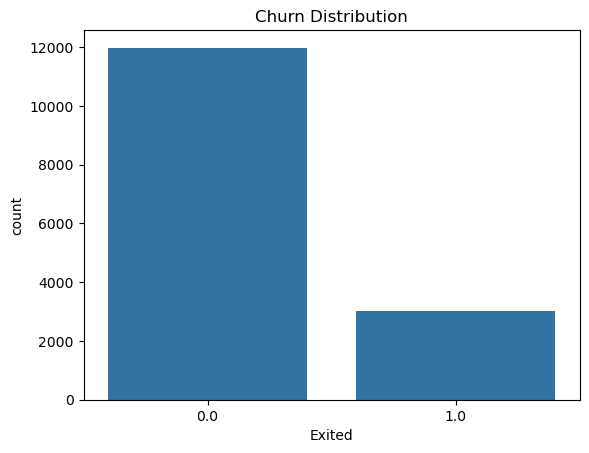

In [4]:
# Visualizing target distribution
sns.countplot(x="Exited", data=df_train)
plt.title("Churn Distribution")
plt.show()

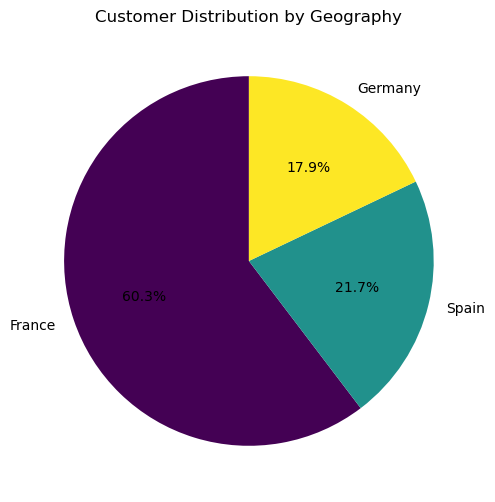

In [5]:
# Population by Geography (Pie Chart)
plt.figure(figsize=(6, 6))
df_train["Geography"].value_counts().plot.pie(autopct="%1.1f%%", startangle=90, cmap="viridis")
plt.title("Customer Distribution by Geography")
plt.ylabel("")
plt.show()

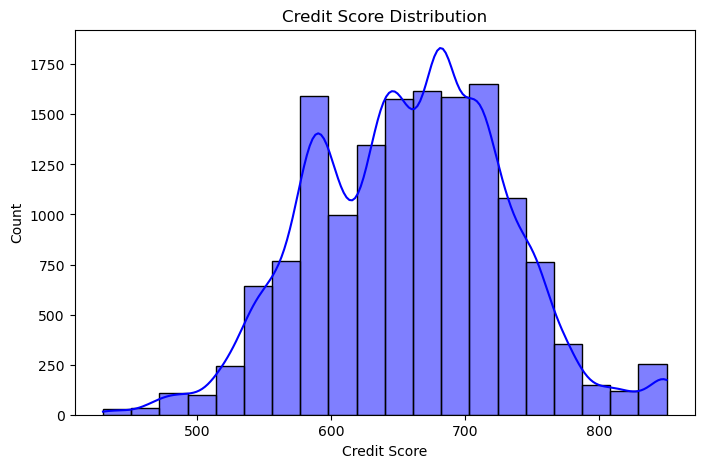

In [6]:
# Credit Score Distribution (Histogram with KDE)
plt.figure(figsize=(8, 5))
sns.histplot(df_train["CreditScore"], bins=20, kde=True, color="blue")
plt.title("Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Count")
plt.show()

C:\Users\honey5\AppData\Local\Temp\ipykernel_1488\1048010649.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Gender", data=df_train, palette="coolwarm")


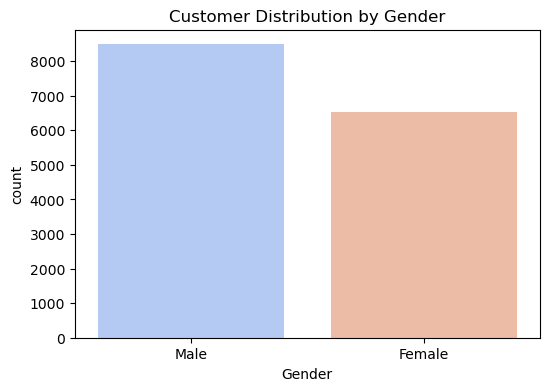

In [7]:
# Gender Distribution (Bar Chart)
plt.figure(figsize=(6, 4))
sns.countplot(x="Gender", data=df_train, palette="coolwarm")
plt.title("Customer Distribution by Gender")
plt.show()

Since not all details are important, we will move on to the first step of feature engineering. columns "ID" and "Exited" were identified as key columns for the submission. As such in this case we will keep the ID column from the test dataset separately and remove fields we do not necessarily need like surname, customerID and ID in the training of our models.

In [8]:
# Preserve ID for submission
ids_test = df_test["id"]

# Drop unnecessary columns
drop_cols = ["id", "CustomerId", "Surname"]
df_train = df_train.drop(columns=drop_cols)
df_test = df_test.drop(columns=drop_cols)

In [9]:
# Encode categorical variables
label_encoders = {}
for col in ["Geography", "Gender"]:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])  # Apply same encoding to test set
    label_encoders[col] = le  # Store encoders for future use

In [10]:
# Split data into features and target
X_train = df_train.drop(columns=["Exited"])
y_train = df_train["Exited"]
X_test = df_test  # No target column in test set

A decision was taken to train three models to see which one gave the best results. these models were chosen due to a number of reasons, including but not limited to:



In [11]:
# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# Train Logistic Regression model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_probs_log = log_model.predict_proba(X_test)[:, 1]

In [13]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]

In [14]:
# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

c:\Users\honey5\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [15]:
# Evaluate models using ROC-AUC on training data
y_train_probs_log = log_model.predict_proba(X_train)[:, 1]
y_train_probs_rf = rf_model.predict_proba(X_train)[:, 1]
y_train_probs_xgb = xgb_model.predict_proba(X_train)[:, 1]

print("Model Performance on Training Data:")
print(f"Logistic Regression AUC: {roc_auc_score(y_train, y_train_probs_log):.4f}")
print(f"Random Forest AUC: {roc_auc_score(y_train, y_train_probs_rf):.4f}")
print(f"XGBoost AUC: {roc_auc_score(y_train, y_train_probs_xgb):.4f}")

Model Performance on Training Data:
Logistic Regression AUC: 0.8718
Random Forest AUC: 1.0000
XGBoost AUC: 0.9895


From the model perfomance it is clear that random forest is the best perfoming model followed by XGBoost. However below below I produced 3 submission files aptly named. 

In [16]:
# Prepare submission files
submission_log = pd.DataFrame({"id": ids_test, "Exited": y_probs_log})
submission_rf = pd.DataFrame({"id": ids_test, "Exited": y_probs_rf})
submission_xgb = pd.DataFrame({"id": ids_test, "Exited": y_probs_xgb})

submission_log.to_csv("submission_logistic.csv", index=False)
submission_rf.to_csv("submission_random_forest.csv", index=False)
submission_xgb.to_csv("submission_xgboost.csv", index=False)

print("Submission files saved:")
print("submission_logistic.csv, submission_random_forest.csv, submission_xgboost.csv")

Submission files saved:
submission_logistic.csv, submission_random_forest.csv, submission_xgboost.csv
